In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np


def log_reader(log_name: str) -> pd.DataFrame:
    """
    逐行读取日志，分割并提取，最后保存为 pandas dataframe
    """
    with open(log_name, 'r', encoding='cp1252') as file:
        # Get the total number of lines in the file
        total_lines = sum(1 for _ in file)

    with open(log_name, 'r', encoding='cp1252') as file:
        split_results = []
        # for line in file:
        for line in tqdm(file, total=total_lines, desc="Reading logs by lines:"):
            words = line.split()[4:]
            word_pair_dict = {}
            for pairs in words:
                try:
                    ls_pairs = pairs.split("=")
                    word_pair_dict[ls_pairs[0]] = ls_pairs[1]
                except IndexError:
                    # ls_pairs = pairs.split("=")
                    # word_pair_dict[ls_pairs[0]] = ""
                    pass
            split_results.append(word_pair_dict)

    results_df = pd.DataFrame(split_results)
    return results_df


def count_column_with_ratios(df_name: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    根据列名分组，分组后计数，计数后进行降序排序
    """
    count_col_name = col_name + "计数"
    col_counts_df = df_name.groupby(col_name).size().reset_index(name=count_col_name)
    sorted_df = col_counts_df.sort_values(by=count_col_name, ascending=False)
    total_counts = sorted_df[count_col_name].sum()
    sorted_df[col_name + "%比"] = sorted_df[count_col_name].apply(lambda x: (round(x / total_counts, 4)) * 100)
    return sorted_df


def select_by_column_name_and_value(df_name: pd.DataFrame, col_name: str, col_value) -> pd.DataFrame:
    """
    选取某行是某值的所有数据
    :param df_name:
    :param col_name:
    :param col_value:
    :return:
    """
    filter_df = df_name.loc[df_name[col_name] == col_value]
    return filter_df


def analysis_selected_dataframe(selected_df: pd.DataFrame) -> pd.DataFrame:
    """
    解析Dataframe表格中的 "service", "srcport", "dstport", "srcip", "dstip" 中的五项指标的计数排名及百分比
    :param selected_df:
    :return:
    """
    # ls_cols=["service", "srcport", "dstport", "srcip", "dstip", "dstcountry"]:
    ls_cols = ["service", "srcport", "dstport", "srcip", "dstip"]
    total_column_list = ['default_1', 'default_2', 'default_3']
    total_ndarray = np.empty((20, 3))
    for col in ls_cols:
        selected_df_col_counts = count_column_with_ratios(selected_df, col).head(20)
        selected_df_col_counts_columns = selected_df_col_counts.columns.tolist()
        selected_df_col_counts_ndarray = selected_df_col_counts.to_numpy()
        total_column_list = total_column_list + selected_df_col_counts_columns
        total_ndarray = np.concatenate((total_ndarray, selected_df_col_counts_ndarray), axis=1)  # 注意指定axis=1以进行横向拼接
    total_dataframe = pd.DataFrame(total_ndarray, columns=total_column_list)
    total_dataframe = total_dataframe.drop(['default_1', 'default_2', 'default_3'], axis=1)
    return total_dataframe


def detail_analysis_by_column_and_value(total_logs_df: pd.DataFrame, col_name: str, col_value):
    """
    解析Dataframe表格中的 "service", "srcport", "dstport", "srcip", "dstip" 中的五项指标的计数排名及百分比
    以及 srccountry 和 dstcountry 2项指标的计数排名及百分比
    并存储为 execl表格
    :param total_logs_df:
    :param col_name:
    :param col_value:
    :return:
    """
    selected_df_by_column_name_and_value = select_by_column_name_and_value(total_logs_df, col_name, col_value)
    detail_result_total_df = analysis_selected_dataframe(selected_df_by_column_name_and_value)
    output_execl_name = ("LongLogsAnalysisResultsTables\\" + col_name + col_value.strip("\"") + "DetailAnalysisResults.xlsx")
    detail_result_total_df.to_excel(output_execl_name, index=False)
    print("DataFrame saved to " + output_execl_name)

    srccountry_col_counts_df = (count_column_with_ratios(selected_df_by_column_name_and_value, 'srccountry').head(20))
    output_execl_name = "LongLogsAnalysisResultsTables\\" + col_name + col_value.strip("\"") + "srccountryResults.xlsx"
    srccountry_col_counts_df.to_excel(output_execl_name, index=False)
    print("DataFrame saved to " + output_execl_name)

    dstcountry_col_counts_df = (count_column_with_ratios(selected_df_by_column_name_and_value, 'dstcountry').head(20))
    output_execl_name = "LongLogsAnalysisResultsTables\\" + col_name + col_value.strip("\"") + "dstcountryResults.xlsx"
    dstcountry_col_counts_df.to_excel(output_execl_name, index=False)
    print("DataFrame saved to " + output_execl_name)

    return detail_result_total_df, srccountry_col_counts_df, dstcountry_col_counts_df


if __name__ == '__main__':
    the_log_short = "message_179.170.130.210.bn.2iij.net_20230930.log"
    the_log_long = "message_179.170.130.210.bn.2iij.net_20231002.log"
    # log_df = log_reader(the_log_short)
    # log_df = log_reader(the_log_long)
    # select_df = select_by_value(log_df, 'logid', log_df.iloc[0]['logid']) # logid = "13"




In [2]:
# all_logs_df = log_reader(the_log_short)
all_logs_df = log_reader(the_log_long)

Reading logs by lines:: 100%|██████████| 1090953/1090953 [00:16<00:00, 66741.37it/s]


In [4]:
all_logs_df.columns

Index(['date', 'time', 'devname', 'devid', 'logid', 'type', 'subtype', 'level',
       'vd', 'eventtime', 'tz', 'srcip', 'srcport', 'srcintf', 'srcintfrole',
       'dstip', 'dstport', 'dstintf', 'dstintfrole', 'sessionid', 'proto',
       'action', 'policyid', 'policytype', 'poluuid', 'service', 'dstcountry',
       'srccountry', 'trandisp', 'transip', 'transport', 'duration',
       'sentbyte', 'rcvdbyte', 'sentpkt', 'rcvdpkt', 'appcat', 'sentdelta',
       'rcvddelta', 'app', 'crscore', 'craction', 'crlevel', 'identifier',
       'logdesc', 'cpu', 'mem', 'totalsession', 'disk', 'bandwidth',
       'setuprate', 'disklograte', 'fazlograte', 'freediskstorage',
       'sysuptime', 'msg', 'tunneltype', 'tunnelid', 'remip', 'user', 'group',
       'dst_host', 'reason', 'interface', 'total', 'used', 'desc', 'status',
       'fcni', 'fdni', 'fsci', 'pid', 'cause', 'auditid', 'audittime',
       'auditscore', 'criticalcount', 'highcount', 'mediumcount', 'lowcount',
       'passedcount', 'dhc

In [4]:
selected_df_col_counts = count_column_with_ratios(all_logs_df, "type").head(20)
selected_df_col_counts

,type,type计数,type%比
1,"""traffic""",1088852,99.81
0,"""event""",2101,0.19


In [57]:
selected_df_col_counts = count_column_with_ratios(all_logs_df, "logid")
selected_df_col_counts

,logid,logid计数,logid%比
1,"""0000000013""",665663,61.02
2,"""0000000020""",217206,19.91
3,"""0001000014""",146339,13.41
0,"""0000000011""",59644,5.47
5,"""0100026001""",854,0.08
10,"""0101039426""",736,0.07
8,"""0100040704""",288,0.03
11,"""0101039943""",87,0.01
6,"""0100026003""",48,0.00
13,"""0101039946""",36,0.00


In [35]:
df_col_level_val_notice = select_by_column_name_and_value(all_logs_df, "level", "\"notice\"")
df_col_level_val_notice_count_service = count_column_with_ratios(df_col_level_val_notice, "service").head(20)
df_col_level_val_notice_count_service.head(20)

,service,service计数,service%比
9,"""HTTPS""",427748,41.56
4,"""DNS""",312476,30.36
5487,"""udp/443""",50665,4.92
8,"""HTTP""",35381,3.44
5522,"""udp/5353""",34786,3.38
46,"""SYSLOG""",33979,3.30
5594,"""udp/8612""",26112,2.54
5542,"""udp/59870""",23315,2.27
5367,"""udp/137""",16478,1.60
5523,"""udp/5355""",7670,0.75


In [22]:
df_col_service_val_https = select_by_column_name_and_value(all_logs_df, "service", "\"HTTPS\"")
df_col_service_val_https.head(20)

,date,time,devname,devid,logid,type,subtype,level,vd,eventtime,...,mediumcount,lowcount,passedcount,status,fcni,fdni,fsci,pid,cause,desc
0,2023-10-02,08:59:59,"""msd-fw_001""","""FGT60FTK20049338""","""0000000013""","""traffic""","""forward""","""notice""","""root""",1696204800039993091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-02,08:59:59,"""msd-fw_001""","""FGT60FTK20049338""","""0000000020""","""traffic""","""forward""","""notice""","""root""",1696204800074757171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-02,08:59:59,"""msd-fw_001""","""FGT60FTK20049338""","""0000000013""","""traffic""","""forward""","""notice""","""root""",1696204800239986611,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10-02,08:59:59,"""msd-fw_001""","""FGT60FTK20049338""","""0000000013""","""traffic""","""forward""","""notice""","""root""",1696204800309987391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2023-10-02,08:59:59,"""msd-fw_001""","""FGT60FTK20049338""","""0000000020""","""traffic""","""forward""","""notice""","""root""",1696204800605421010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2023-10-02,08:59:59,"""msd-fw_001""","""FGT60FTK20049338""","""0000000020""","""traffic""","""forward""","""notice""","""root""",1696204800605030391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2023-10-02,08:59:59,"""msd-fw_001""","""FGT60FTK20049338""","""0000000020""","""traffic""","""forward""","""notice""","""root""",1696204800605419090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2023-10-02,08:59:59,"""msd-fw_001""","""FGT60FTK20049338""","""0000000020""","""traffic""","""forward""","""notice""","""root""",1696204800605422070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2023-10-02,08:59:59,"""msd-fw_001""","""FGT60FTK20049338""","""0000000020""","""traffic""","""forward""","""notice""","""root""",1696204800605415510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2023-10-02,08:59:59,"""msd-fw_001""","""FGT60FTK20049338""","""0000000020""","""traffic""","""forward""","""notice""","""root""",1696204800605441930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_col_service_val_https_counts_service = count_column_with_ratios(df_col_service_val_https, "dstcountry").head(20)
df_col_service_val_https_counts_service

,dstcountry,dstcountry计数,dstcountry%比
20,"""Japan""",284130,60.40
39,"""United",109482,23.28
31,"""Singapore""",18323,3.90
15,"""India""",17501,3.72
0,"""Australia""",8075,1.72
6,"""China""",7181,1.53
21,"""Korea,",6756,1.44
12,"""Hong",5929,1.26
17,"""Ireland""",5037,1.07
24,"""Netherlands""",2492,0.53


In [21]:
df_col_type_val_traffic_counts_service = count_column_with_ratios(df_col_type_val_traffic, "reason").head(20)
df_col_type_val_traffic_counts_service

,reason,reason计数,reason%比


In [33]:
df_col_service_counts = count_column_with_ratios(all_logs_df, "level").head(20)
df_col_service_counts

,level,level计数,level%比
2,"""notice""",1029527,94.37
3,"""warning""",59644,5.47
1,"""information""",1046,0.10
0,"""alert""",736,0.07


In [21]:
df_col_service_counts = count_column_with_ratios(all_logs_df, "service").head(20)
df_col_service_counts

,service,service计数,service%比
9,"""HTTPS""",470381,43.20
4,"""DNS""",326867,30.02
5488,"""udp/443""",51738,4.75
8,"""HTTP""",36026,3.31
5523,"""udp/5353""",34786,3.19
46,"""SYSLOG""",33979,3.12
5595,"""udp/8612""",26122,2.40
5543,"""udp/59870""",23315,2.14
5368,"""udp/137""",16478,1.51
5524,"""udp/5355""",7670,0.70


In [36]:
df_col_service_counts = count_column_with_ratios(all_logs_df, "srcintf").head(20)
df_col_service_counts

,srcintf,srcintf计数,srcintf%比
0,"""internal""",1041896,95.69
1,"""unknown0""",34996,3.21
2,"""wan2""",11960,1.10


In [37]:
df_col_service_counts = count_column_with_ratios(all_logs_df, "srcintfrole").head(20)
df_col_service_counts

,srcintfrole,srcintfrole计数,srcintfrole%比
0,"""lan""",1041896,95.69
1,"""undefined""",34996,3.21
2,"""wan""",11960,1.10


In [38]:
df_col_service_counts = count_column_with_ratios(all_logs_df, "dstintf").head(20)
df_col_service_counts

,dstintf,dstintf计数,dstintf%比
2,"""wan2""",977155,89.74
1,"""unknown0""",111621,10.25
0,"""internal""",76,0.01


In [45]:
df_col_service_counts = count_column_with_ratios(all_logs_df, "appcat").head(20)
df_col_service_counts

,appcat,appcat计数,appcat%比
0,"""unscanned""",1088852,100.0


In [66]:
df_logid_13 = select_by_column_name_and_value(all_logs_df, 'logid', all_logs_df.iloc[0]['logid']) 
df_col_service_counts = count_column_with_ratios(df_logid_13, "subtype").head(20)
df_col_service_counts

,subtype,subtype计数,subtype%比
0,"""forward""",665663,100.0


In [67]:
df_logid_20 = select_by_column_name_and_value(all_logs_df, 'logid', all_logs_df.iloc[1]['logid']) 
df_col_service_counts = count_column_with_ratios(df_logid_20, "subtype").head(20)
df_col_service_counts

,subtype,subtype计数,subtype%比
0,"""forward""",217206,100.0


In [68]:
df_logid_14 = select_by_column_name_and_value(all_logs_df, 'logid', all_logs_df.iloc[53]['logid']) 
df_col_service_counts = count_column_with_ratios(df_logid_14, "subtype").head(20)
df_col_service_counts

,subtype,subtype计数,subtype%比
0,"""local""",146339,100.0


In [69]:
df_logid_11 = select_by_column_name_and_value(all_logs_df, 'logid', all_logs_df.iloc[12]['logid']) 
df_col_service_counts = count_column_with_ratios(df_logid_11, "subtype").head(20)
df_col_service_counts

,subtype,subtype计数,subtype%比
0,"""forward""",59644,100.0


In [65]:
detail_analysis_by_column_and_value(all_logs_df, 'logid', all_logs_df.iloc[12]['logid'])

DataFrame saved to LongLogsAnalysisResultsTables\logid0000000011DetailAnalysisResults.xlsx
DataFrame saved to LongLogsAnalysisResultsTables\logid0000000011srccountryResults.xlsx
DataFrame saved to LongLogsAnalysisResultsTables\logid0000000011dstcountryResults.xlsx


(        service service计数 service%比 srcport srcport计数 srcport%比 dstport  \
 0       "HTTPS"     42633     71.48   16403        24      0.04     443   
 1         "DNS"     14391     24.13   57672        14      0.02      53   
 2     "udp/443"      1073       1.8   52772        14      0.02      80   
 3        "HTTP"       645      1.08   52629        13      0.02    5223   
 4    "icmp/0/8"       455      0.76   60664        13      0.02   38003   
 5    "tcp/5223"       101      0.17   50249        13      0.02    8106   
 6   "tcp/38003"        77      0.13   50564        12      0.02    8080   
 7    "tcp/8106"        46      0.08   53083        12      0.02    8000   
 8    "tcp/8080"        27      0.05   53772        12      0.02     993   
 9    "udp/8000"        25      0.04   49888        12      0.02     853   
 10      "IMAPS"        13      0.02   57868        12      0.02    3482   
 11    "tcp/853"        12      0.02   53037        12      0.02    8612   
 12     "udp

In [81]:
print(all_logs_df.columns)
print("index = 0 value = " + all_logs_df.iloc[0]['logid'])
print("index = 1 value = " + all_logs_df.iloc[1]['logid'])
print("index = 12 value = " + all_logs_df.iloc[12]['logid'])
print("index = 53 value = " + all_logs_df.iloc[53]['logid'])
print("index = 827 value = " + all_logs_df.iloc[827]['logid'])
print("index = 1399 value = " + all_logs_df.iloc[1399]['logid'])
print("index = 3611 value = " + all_logs_df.iloc[3611]['logid'])
print("index = 15150 value = " + all_logs_df.iloc[15150]['logid'])
print("index = 100068 value = " + all_logs_df.iloc[100068]['logid'])
print("index = 612439 value = " + all_logs_df.iloc[612439]['logid'])
print("index = 613245 value = " + all_logs_df.iloc[613245]['logid'])
print("index = 756415 value = " + all_logs_df.iloc[756415]['logid'])
print("index = 913468 value = " + all_logs_df.iloc[913468]['logid'])
print("index = 921527 value = " + all_logs_df.iloc[921527]['logid'])
print("index = 804075 value = " + all_logs_df.iloc[804075]['logid'])
print("index = 984182 value = " + all_logs_df.iloc[984182]['logid'])

Index(['date', 'time', 'devname', 'devid', 'logid', 'type', 'subtype', 'level',
       'vd', 'eventtime', 'tz', 'srcip', 'srcport', 'srcintf', 'srcintfrole',
       'dstip', 'dstport', 'dstintf', 'dstintfrole', 'sessionid', 'proto',
       'action', 'policyid', 'policytype', 'poluuid', 'service', 'dstcountry',
       'srccountry', 'trandisp', 'transip', 'transport', 'duration',
       'sentbyte', 'rcvdbyte', 'sentpkt', 'rcvdpkt', 'appcat', 'sentdelta',
       'rcvddelta', 'crscore', 'craction', 'crlevel', 'app', 'identifier',
       'logdesc', 'interface', 'dhcp_msg', 'mac', 'ip', 'lease', 'hostname',
       'msg', 'tunneltype', 'tunnelid', 'remip', 'user', 'group', 'dst_host',
       'reason', 'cpu', 'mem', 'totalsession', 'disk', 'bandwidth',
       'setuprate', 'disklograte', 'fazlograte', 'freediskstorage',
       'sysuptime', 'total', 'used', 'auditid', 'audittime', 'auditscore',
       'criticalcount', 'highcount', 'mediumcount', 'lowcount', 'passedcount',
       'status', 'fcni'

In [90]:
df_logid_xxx = select_by_column_name_and_value(all_logs_df, 'logid', all_logs_df.iloc[984182]['logid']) 
print(count_column_with_ratios(df_logid_xxx, "type").head(20))
print(count_column_with_ratios(df_logid_xxx, "subtype").head(20))
print(count_column_with_ratios(df_logid_xxx, "level").head(20))
print(count_column_with_ratios(df_logid_xxx, "msg").head(20))
print(count_column_with_ratios(df_logid_xxx, "logdesc").head(20))
print(count_column_with_ratios(df_logid_xxx, "desc").head(20))
print(count_column_with_ratios(df_logid_xxx, "reason").head(20))

      type  type计数  type%比
0  "event"       1   100.0
  subtype  subtype计数  subtype%比
0  "user"          1      100.0
      level  level计数  level%比
0  "notice"        1    100.0
          msg  msg计数  msg%比
0  "Reseeding      1  100.0
    logdesc  logdesc计数  logdesc%比
0  "Seeding          1      100.0
Empty DataFrame
Columns: [desc, desc计数, desc%比]
Index: []
Empty DataFrame
Columns: [reason, reason计数, reason%比]
Index: []


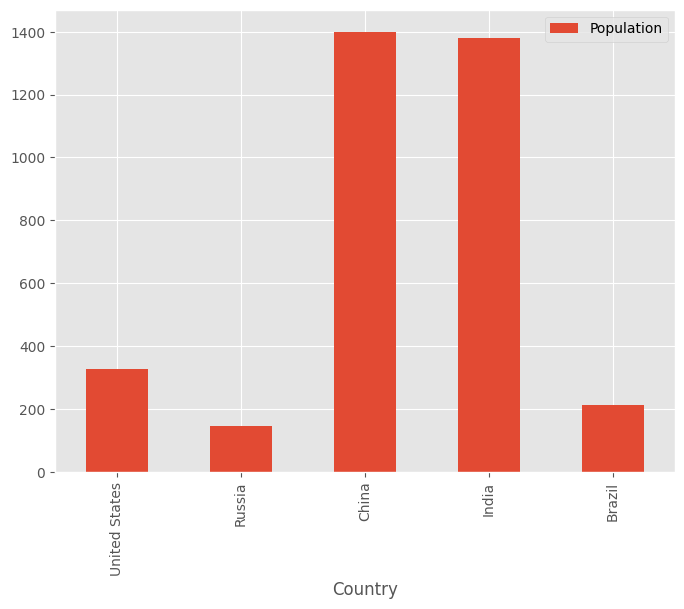

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Country': ['United States', 'Russia', 'China', 'India', 'Brazil'],
    'Population': [328, 144, 1400, 1380, 212],
    'Area (millions of km²)': [9.8, 17.1, 9.6, 3.3, 8.5]
}

df = pd.DataFrame(data)

plt.style.use('ggplot')

df.plot(kind='bar', x='Country', y='Population', figsize=(8, 6))
plt.savefig('population.png', format='png', dpi=300)